## Multilayer Perceptron

**References:**
1. [Building makemore Part 2: MLP](https://www.youtube.com/watch?v=TCH_1BHY58I&t=30s&ab_channel=AndrejKarpathy)

2. [Bengio et al. 2003 MLP language model paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)


In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2022-11-28 10:23:08--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2022-11-28 10:23:08 (8.34 MB/s) - ‘names.txt’ saved [228145/228145]



## Load data

In [4]:
words = open("names.txt", "r").read().splitlines()

In [5]:
chars = sorted(list(set("".join(words))))
stoi = {s:idx + 1 for idx, s in enumerate(chars)}
stoi["."] = 0
itos = {idx: s for s, idx in stoi.items()}

In [6]:
[0] * 3

[0, 0, 0]

## Network architecture

We will be implementing the following network proposed in the paper [2].

**Idea:**

In [2] they propose a word level language model, i.e they predict the next word given a set of k words. Each word is represented or embedded as a 30 dimensional vector (i.e a point in the 30 dimensional space). Initially this words are spread out randomly, using backpropagation we tune the embeddings (i.e the points will move around the 30d space during training). Our goal is to cluster the words of similar meaning close to each other. During training we maximuize the log likelihood on training data (i.e given a set of words x_i = [w1, w2, w3, .., wk] maximize the probability of P(y_hat = y_i)).

**Why does it work ?**

Suppose that we wan't to predict the next word for the following sentance: *the dog was running in a <?>*.

Now suppose we never saw this sentence during training, but we saw the following sentence: *a cat is running in the room*.
The sentences are not exactly the same, but it may happen that the words *the* and *a* and *dog* and *cat* are close in the 30 dimensional space (i.e they are often used in the same context). The network can transfer knowledge through the embedding space and predict the next word of an unseen sentence.


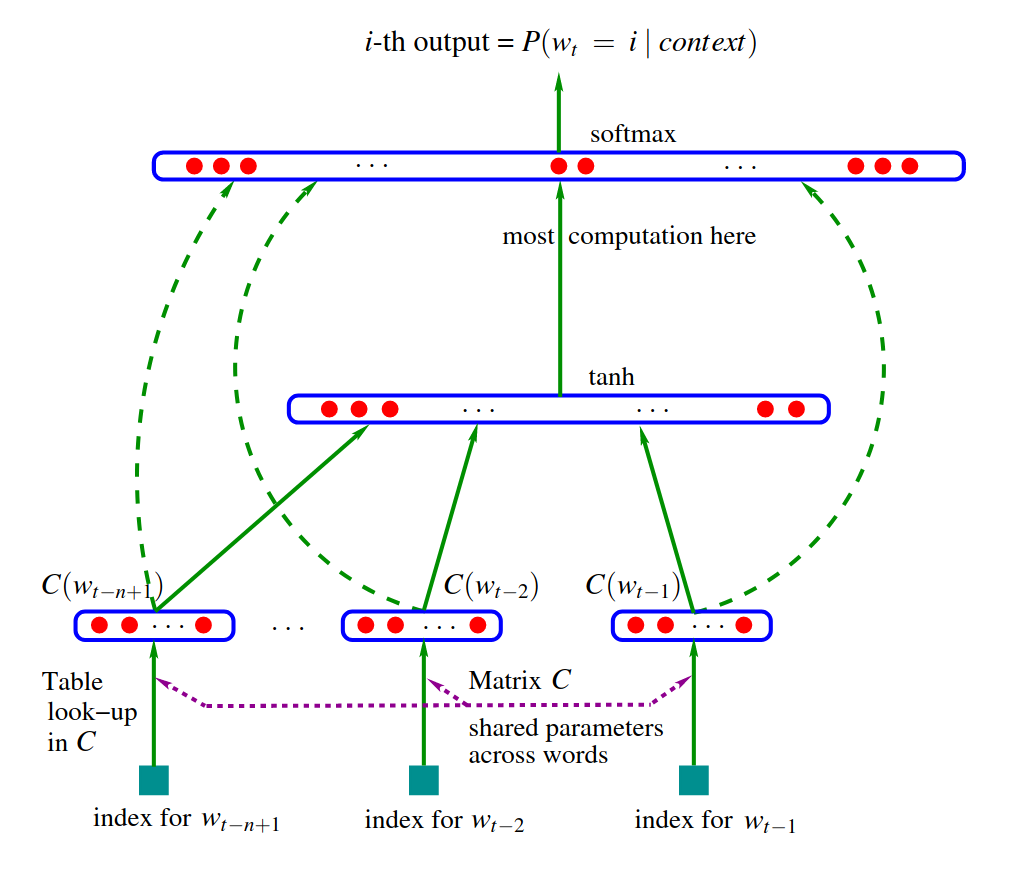

**Architecure:**

1. At the bottom we have a set of three characters (indicies of characters).
2. First we perform the embedding using the parameter matrix C, i.e we simply index the embedding vector in C using the three character indices. 
3. We have a fully connected layer between each embedding and the tanh layer
4. Finally we have another fully connected layer which applies the softmax function such that we get the probability distribution over the predicted (next) characters.

**Parameters** are the parameters of the lookup table C, parameters of the hidden layer (weights and biases) and parameters of the last layer (weights and biases).

## Generate training data

input to the network is the tensor x which is of shape (num_samples, block_size) where block_size is the number of characters used to predict the next one.

e.g block_size=3

x[i] = [0, 12, 4]

y[i] = [2]

In [80]:
def build_dataset(words):  
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [81]:
x, y = build_dataset(words)

torch.Size([228146, 3]) torch.Size([228146])


In [8]:
# Number of characters to take to predict the next one.
block_size = 3
x, y = [], []

# Iterate over words
for w in words:
    context = [0 for _ in range(block_size)]
    
    for ch in w + ".":
        idx = stoi[ch]
        x.append(context)
        y.append(idx)
        context = context[1: ] + [idx]

x = torch.tensor(x)
y = torch.tensor(y)

In [9]:
x.shape

torch.Size([228146, 3])

In [10]:
y.shape

torch.Size([228146])

## Implementing the embedding lookup table

In [11]:
# We'll start by using 3 numbers to embedd each of the 27 characters.
embedding_size = 2
C = torch.randn((27, embedding_size))
C

tensor([[-1.1832, -1.1540],
        [-1.2461,  1.9495],
        [ 1.3371, -0.7805],
        [ 0.7541,  0.7355],
        [ 1.0808, -1.9826],
        [-0.1461, -1.2939],
        [ 0.0120,  0.3250],
        [-0.2209,  0.1022],
        [-0.7349,  0.5654],
        [ 1.5051,  0.4556],
        [ 1.1300,  0.6029],
        [-1.1043, -0.0889],
        [-0.1916, -1.6474],
        [-2.2154,  0.3648],
        [-0.0035, -0.8064],
        [ 0.5228, -0.2965],
        [-1.1038,  0.8034],
        [-0.8864, -0.2148],
        [ 0.0945, -1.0215],
        [-1.0623,  0.5789],
        [-1.5308, -0.6074],
        [ 3.4938, -0.4661],
        [ 0.0999,  0.3395],
        [-0.1470,  1.0448],
        [ 1.5497,  0.8032],
        [ 0.4496, -1.3620],
        [ 1.8172, -0.5378]])

**Embedding a single integer**

we can simply index into the embedding lookup table, or use matrix multiplication with one hot encoded integer. We could use either of the two approaches, this time we will stick with the indexing approach.

In [12]:
C[5]

tensor([-0.1461, -1.2939])

In [13]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.1461, -1.2939])

**Embedding a single example from the dataset**

In [14]:
C[x[0]]

tensor([[-1.1832, -1.1540],
        [-1.1832, -1.1540],
        [-1.1832, -1.1540]])

**Embedding the whole dataset**

Each sample is represented by a 3 x 2 matrix.

In [15]:
emb = C[x]
emb.shape

torch.Size([228146, 3, 2])

In [16]:
emb[0]

tensor([[-1.1832, -1.1540],
        [-1.1832, -1.1540],
        [-1.1832, -1.1540]])

## Constructing the hidden layer

In [17]:
block_size

3

In [18]:
embedding_size

2

In [19]:
w1 = torch.randn((block_size * embedding_size, 
                100) # 100 is a hyperparamter
)

b1 = torch.randn(100)

In [20]:
emb @ w1 + b1

RuntimeError: ignored

**Reshapeing the emb matrix**

Our goal is to reshape the emb vector (m, 3, 2) into a vector of shape (m, 6).

In [21]:
# tuple of all block_size dimensions
for i in range(block_size):
    print(torch.unbind(emb, dim=1)[i].shape)

torch.Size([228146, 2])
torch.Size([228146, 2])
torch.Size([228146, 2])


In [22]:
t1 = torch.unbind(emb, dim=1)
print(t1[0][:1])
print(t1[1][:1])
print(t1[1][:1])

tensor([[-1.1832, -1.1540]])
tensor([[-1.1832, -1.1540]])
tensor([[-1.1832, -1.1540]])


In [23]:
t2 = torch.cat(torch.unbind(emb, dim=1), dim=1)
t2[0, :]

tensor([-1.1832, -1.1540, -1.1832, -1.1540, -1.1832, -1.1540])

The most efficient way of doing this:

In [24]:
m = emb.shape[0]
emb.view(m, 6)

tensor([[-1.1832, -1.1540, -1.1832, -1.1540, -1.1832, -1.1540],
        [-1.1832, -1.1540, -1.1832, -1.1540, -0.1461, -1.2939],
        [-1.1832, -1.1540, -0.1461, -1.2939, -2.2154,  0.3648],
        ...,
        [ 1.8172, -0.5378,  1.8172, -0.5378,  0.4496, -1.3620],
        [ 1.8172, -0.5378,  0.4496, -1.3620,  1.8172, -0.5378],
        [ 0.4496, -1.3620,  1.8172, -0.5378,  1.5497,  0.8032]])

In [25]:
emb.view(m, 6) == torch.cat(torch.unbind(emb, dim=1), dim=1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        ...,
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True]])

Long story short:

In [26]:
h = torch.tanh(emb.view(emb.shape[0], 6) @ w1 + b1)
h.shape

torch.Size([228146, 100])

## Create the final layer

In [27]:
w2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [28]:
logits = h @ w2 + b2
logits.shape

torch.Size([228146, 27])

In [29]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)

In [30]:
# each row sums to one
probs.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])

In [31]:
torch.arange(emb.shape[0])

tensor([     0,      1,      2,  ..., 228143, 228144, 228145])

**recall negative log likelihood**

In [32]:
probs[torch.arange(emb.shape[0]), y].shape

torch.Size([228146])

In [33]:
# Negative log likelihood
loss = -probs[torch.arange(emb.shape[0]), y].log().mean()

## Putting it all together



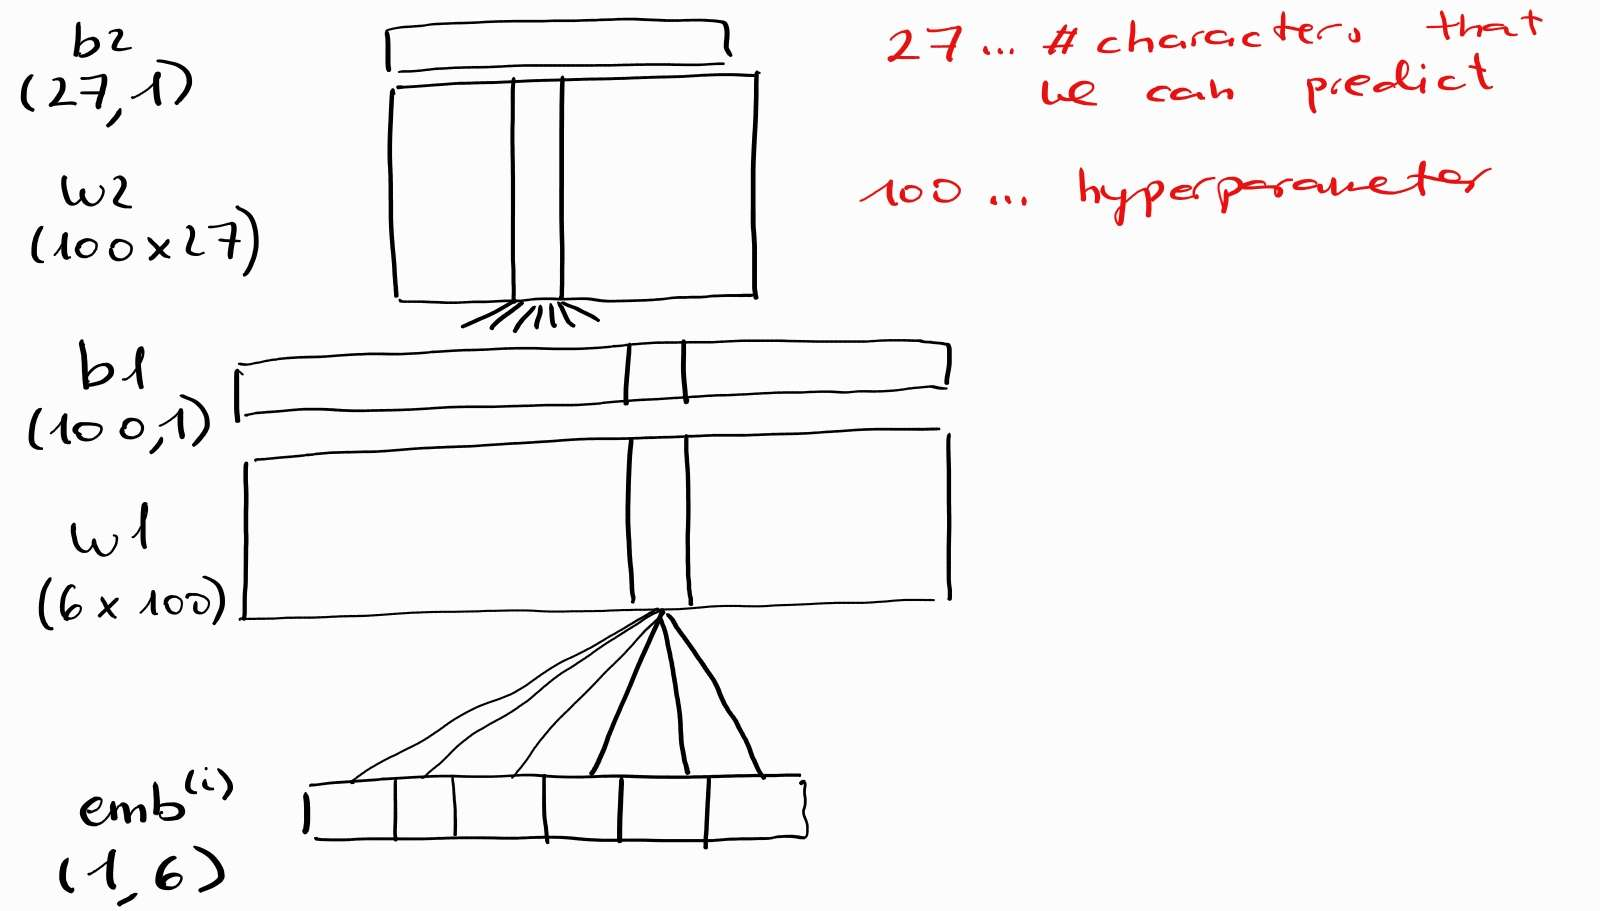

In [34]:
g = torch.Generator().manual_seed(2147483647)
c = torch.randn((27, 2), generator=g)
w1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
w2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
params = [c, w1, b1, w2, b2]

In [35]:
# number of parameters to optimize
sum(p.nelement() for p in params)

3481

**Note that here we use the cross_entropy and not the negative log likelihood.**

Reasons for this are as follows:
1. **cross_entropy** is a higher level implementation so we have a **single high gradient** to compute for it, log likehood is composed of many little operations (exp, log, ..) which we have to compute gradients for. So **cross_entropy is more efficient to compute.**
2. cross_entropy **is also more numerically stable**.

In [36]:
emd = c[x]
h = torch.tanh(emd.view(emd.shape[0], 6) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, y)
loss

tensor(19.5052)

**Problem with log likelihood:** We see that for relatively small values (e.g 100) we get a infinite value when taking the exp of that value.

In [37]:
logists = torch.tensor([-100, -3, 0, 100])
counts = logists.exp()
print(counts)
probas = counts / counts.sum()
print(probas)

tensor([3.7835e-44, 4.9787e-02, 1.0000e+00,        inf])
tensor([0., 0., 0., nan])


PyTorch handles this by subtracting a constant value from the logits, this does not effect the outcume, since we are normalizing the output.

In [38]:
OFFSET_VAL = 100

logists = torch.tensor([-100, -3, 0, 100]) - OFFSET_VAL
counts = logists.exp()
print(counts)
probas = counts / counts.sum()
print(probas)

tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])
tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])


## Training the neural network

**Overfitting the first batch**

In [60]:
BATCH_SIZE = 32
x_batch = x[: BATCH_SIZE, :]
y_batch = y[: BATCH_SIZE]
x_batch.shape
y_batch.shape

torch.Size([32])

In [62]:
LEARN_RATE = 0.1
N_ITERS = 100

g = torch.Generator().manual_seed(2147483647)
c = torch.randn((27, 2), generator=g)
w1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
w2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
params = [c, w1, b1, w2, b2]

# Make sure to enable gradients!
for p in params:
    p.requires_grad = True

# Training loop
for k in range(N_ITERS):
    # Forward pass
    emb = c[x_batch]
    h = torch.tanh(emb.view(-1, 6) @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y_batch)

    # Backward pass

    # Zero all of the gradietns
    for p in params:
        p.grad = None

    loss.backward()

    # Update the parameters
    for p in params:
        p.data = p.data - LEARN_RATE * p.grad

print(f"loss: {loss.item()}")

loss: 0.3367388844490051


**Inspect the predictions on the first batch of data**


We are not able to overfit the batch because our data is ambiguous, i.e a set of three characters may map to more than one next character. In sample where we have a unique mapping (i.e unique input and unique output) we are able to overfit the outputs.

e.g

```
x --> y
... --> a
... --> o
... --> s
```

In [67]:
# Prediciton for the 0th sample
logits[0, :]

tensor([  5.6152,  11.3379,   6.1462,   3.8517,  -2.1464,  11.2813, -18.8963,
          5.1576,  -4.0152,  11.3223,   6.4054,  -1.0649,   0.6911,   7.9035,
          1.6204,  11.2467,   1.8672,   7.0337,  -0.7938,  11.3119,  -0.3728,
          5.8304,   3.6406,  -5.9184,   7.7136,  -4.0840,   6.1745],
       grad_fn=<SliceBackward0>)

In [68]:
# Predictions for all samples
logits.argmax(1)

tensor([ 1, 13, 13,  1,  0,  1, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  1, 19,
         1,  2,  5, 12, 12,  1,  0,  1, 15, 16,  8,  9,  1,  0])

In [71]:
y_batch

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [72]:
logits.argmax(1) == y_batch

tensor([False,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True])

**Train the whole network**

We will use mini-batch gradient descent. Note that the direction of mini batch gradient is not as good as the direction of batch gradient but it allows us to perform more itterations, so we prefer it.

In [88]:
LEARN_RATE = 0.1
BATCH_SIZE = 32
N_ITERS = 1250

g = torch.Generator().manual_seed(2147483647)
c = torch.randn((27, 2), generator=g)
w1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
w2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
params = [c, w1, b1, w2, b2]

# Make sure to enable gradients!
for p in params:
    p.requires_grad = True

# Training loop
losses = []
for k in range(N_ITERS):
    # Perform mini-batch gradient descent
    rand_idxs = torch.randint(0, x.shape[0], (BATCH_SIZE, ))
    x_batch = x[rand_idxs]
    y_batch = y[rand_idxs]

    # Forward pass
    emb = c[x_batch]
    h = torch.tanh(emb.view(-1, 6) @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y_batch)
    losses.append(loss.item())

    # Backward pass

    # Zero all of the gradietns
    for p in params:
        p.grad = None

    loss.backward()

    # Update the parameters
    for p in params:
        p.data = p.data - LEARN_RATE * p.grad

print(f"loss: {loss.item()}")

loss: 2.429121971130371


In [89]:
rand_idxs = torch.randint(0, x.shape[0], (32, ))

In [90]:
emb = c[x]
h = torch.tanh(emb.view(-1, 6) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, y)
print(f"loss (whole dataset): {loss}")

loss (whole dataset): 2.6382064819335938


**Determening the learning rate**

In [95]:
BATCH_SIZE = 32
N_ITERS = 100

g = torch.Generator().manual_seed(2147483647)
c = torch.randn((27, 2), generator=g)
w1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
w2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
params = [c, w1, b1, w2, b2]

# Make sure to enable gradients!
for p in params:
    p.requires_grad = True

# Training loop
losses = {}
for lr in [0.0001, 0.001, 0.1, 0.5, 1.0]:
    losses[lr] = []
    for k in range(N_ITERS):
        # Perform mini-batch gradient descent
        rand_idxs = torch.randint(0, x.shape[0], (BATCH_SIZE, ))
        x_batch = x[rand_idxs]
        y_batch = y[rand_idxs]

        # Forward pass
        emb = c[x_batch]
        h = torch.tanh(emb.view(-1, 6) @ w1 + b1)
        logits = h @ w2 + b2
        loss = F.cross_entropy(logits, y_batch)
        losses[lr].append(loss.item())

        # Backward pass

        # Zero all of the gradietns
        for p in params:
            p.grad = None

        loss.backward()

        # Update the parameters
        for p in params:
            p.data = p.data - lr * p.grad

[]

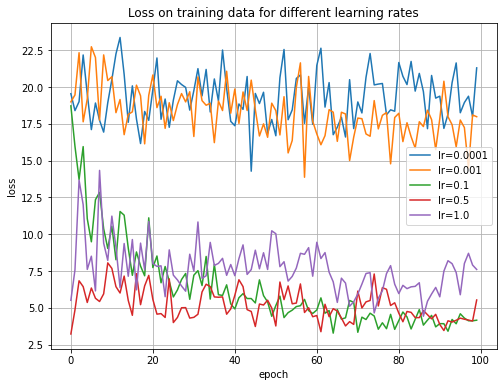

In [99]:
plt.figure(figsize=(8, 6))
for lr, loss_vect in losses.items():
    plt.plot(loss_vect, label=f"lr={lr}")

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss on training data for different learning rates")
plt.legend()
plt.grid() 
plt.plot()

**Better approach**

In [111]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [112]:
BATCH_SIZE = 32
N_ITERS = 100

g = torch.Generator().manual_seed(2147483647)
c = torch.randn((27, 2), generator=g)
w1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
w2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
params = [c, w1, b1, w2, b2]

# Make sure to enable gradients!
for p in params:
    p.requires_grad = True

In [113]:
# Training loop
lri = []
losses = []
n_iters = len(lrs)

for k in range(n_iters):
    # Perform mini-batch gradient descent
    rand_idxs = torch.randint(0, x.shape[0], (BATCH_SIZE, ))
    x_batch = x[rand_idxs]
    y_batch = y[rand_idxs]

    # Forward pass
    emb = c[x_batch]
    h = torch.tanh(emb.view(-1, 6) @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y_batch)

    # Backward pass

    # Zero all of the gradietns
    for p in params:
        p.grad = None

    loss.backward()

    # Update the parameters
    for p in params:
        curr_learn_rate = lrs[k]
        p.data = p.data -  curr_learn_rate * p.grad

    lri.append(curr_learn_rate)
    losses.append(loss.data)

**Learn rate vs loss plots**

We pick the learning rate assocaited with the minima in the curve ploted bellow, it seems like picking `lr=0.1` would work fine.

[]

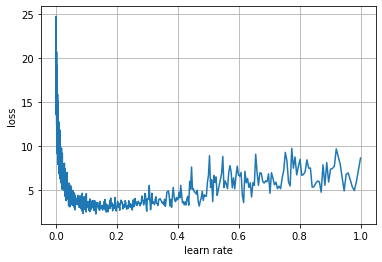

In [116]:
plt.plot(lri, losses)
plt.xlabel("learn rate")
plt.ylabel("loss")
plt.grid() 
plt.plot()

**Training approach**

Find decent learning rate, using approach presented above, than decay (e.g divide it by 10) the learning rate after some iterations (i.e smaller steps at the end of the optimization). 

In [123]:
LEARN_RATE = 0.1
BATCH_SIZE = 32
N_ITERS = 30000

g = torch.Generator().manual_seed(2147483647)
c = torch.randn((27, 2), generator=g)
w1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
w2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
params = [c, w1, b1, w2, b2]

# Make sure to enable gradients!
for p in params:
    p.requires_grad = True

# Training loop
losses = []
for k in range(N_ITERS):
    # Perform mini-batch gradient descent
    rand_idxs = torch.randint(0, x.shape[0], (BATCH_SIZE, ))
    x_batch = x[rand_idxs]
    y_batch = y[rand_idxs]

    # Forward pass
    emb = c[x_batch]
    h = torch.tanh(emb.view(-1, 6) @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y_batch)
    losses.append(loss.item())

    # Backward pass

    # Zero all of the gradietns
    for p in params:
        p.grad = None

    loss.backward()

    # Update the parameters

    # decay the learning rate:
    if k > 20000:
        lr = 0.01

    for p in params:
        p.data = p.data - LEARN_RATE * p.grad

print(f"loss: {loss.item()}")

loss: 2.2999346256256104


Note that the curve is slighly noisy, this is beacuse we are computing gradients using mini-batch training.

[]

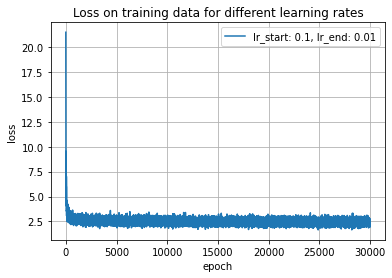

In [125]:
plt.plot(losses, label=f"lr_start: 0.1, lr_end: 0.01")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss on training data for different learning rates")
plt.legend()
plt.grid() 
plt.plot()

## Splitting the data (train, val, test)

In [133]:
# compute random indices.
m = len(x)

rand_idxs = torch.randperm(m)
# shuffle the data.
x = x[rand_idxs]
y = y[rand_idxs]
n1 = int(0.8 * m)
n2 = int(0.9 * m)

x_train = x[:n1]
y_train = y[:n1]
x_val = x[n1:n2]
y_val = y[n1:n2]
x_test = x[n2:]
y_test = y[n2:]

In [134]:
x_train.shape, y_train.shape

(torch.Size([25626, 3]), torch.Size([25626]))

In [142]:
LEARN_RATE = 0.1
BATCH_SIZE = 32
N_ITERS = 30000

g = torch.Generator().manual_seed(2147483647)
c = torch.randn((27, 2), generator=g)
w1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
w2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
params = [c, w1, b1, w2, b2]

# Make sure to enable gradients!
for p in params:
    p.requires_grad = True

# Training loop
losses = []
for k in range(N_ITERS):
    # Perform mini-batch gradient descent
    rand_idxs = torch.randint(0, x_train.shape[0], (BATCH_SIZE, ))
    x_batch = x_train[rand_idxs]
    y_batch = y_train[rand_idxs]

    # Forward pass
    emb = c[x_batch]
    h = torch.tanh(emb.view(-1, 6) @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y_batch)
    losses.append(loss.item())

    # Backward pass

    # Zero all of the gradietns
    for p in params:
        p.grad = None

    loss.backward()

    # Update the parameters

    # decay the learning rate:
    if k > 20000:
        lr = 0.01

    for p in params:
        p.data = p.data - LEARN_RATE * p.grad

print(f"loss: {loss.item()}")

loss: 1.9325354099273682


In [143]:
emb = c[x]
h = torch.tanh(emb.view(-1, 6) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, y)
print(f"loss (whole dataset): {loss}")

loss (whole dataset): 2.4092326164245605


In [144]:
emb = c[x_val]
h = torch.tanh(emb.view(-1, 6) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, y_val)
print(f"loss (validation set): {loss}")

loss (validation set): 2.465691089630127


## Bulding a larger network

Increase the hiden layer dimension. Another option is to incease the dimension of the embedding matix, it could be that we are *cramming* too many characters into the 2 dimensions (network may not be able to use that space effectively).

In [176]:
BATCH_SIZE = 32
N_ITERS = 100

g = torch.Generator().manual_seed(2147483647)
c = torch.randn((27, 2), generator=g)
w1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
w2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
params = [c, w1, b1, w2, b2]

# Make sure to enable gradients!
for p in params:
    p.requires_grad = True

In [177]:
# number of parameters to optimize
sum(p.nelement() for p in params)

10281

In [190]:
LEARN_RATE = 0.005
BATCH_SIZE = 32

# Make sure to enable gradients!
for p in params:
    p.requires_grad = True

# Training loop
losses = []
for k in range(30000):
    # Perform mini-batch gradient descent
    rand_idxs = torch.randint(0, x_train.shape[0], (BATCH_SIZE, ))
    x_batch = x_train[rand_idxs]
    y_batch = y_train[rand_idxs]

    # Forward pass
    emb = c[x_batch]
    h = torch.tanh(emb.view(-1, 6) @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y_batch)
    losses.append(loss.item())

    # Backward pass

    # Zero all of the gradietns
    for p in params:
        p.grad = None

    loss.backward()

    # Update the parameters

    # decay the learning rate:
    # if k > 20000:
    #     lr = 0.01

    for p in params:
        p.data = p.data - LEARN_RATE * p.grad

print(f"loss: {loss.item()}")

loss: 2.4887535572052


In [194]:
emb = c[x]
h = torch.tanh(emb.view(-1, 6) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, y)
print(f"loss (whole dataset): {loss}")

loss (whole dataset): 2.2954623699188232


In [195]:
emb = c[x_val]
h = torch.tanh(emb.view(-1, 6) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, y_val)
print(f"loss (validation set): {loss}")

loss (validation set): 2.3593990802764893


## Visulize the character embedding.

**Analysis of the embedding space**

We can see that the network has clustered the embeddings of characters which often coexist. 

For example we see a cluster of *a,o,u,e* (neural network treats this embeddings (i.e letters) as very similar, beacuse when we feed them to the neural network the value of the embedding is very similar).

We see that *g* and *e* are treated as an exception.

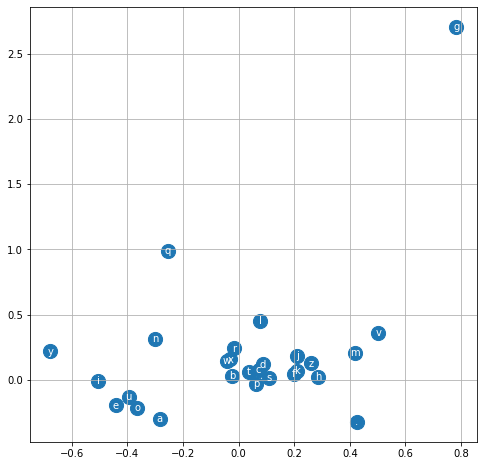

In [200]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(c[:,0].data, c[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(c[i,0].item(), c[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

## Scaling up the embedding matrix

Note that if we do this we won't be able to visualize the embeddings anymore.

In [201]:
BATCH_SIZE = 32
N_ITERS = 100

g = torch.Generator().manual_seed(2147483647)
c = torch.randn((27, 10), generator=g)
w1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
w2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
params = [c, w1, b1, w2, b2]

# Make sure to enable gradients!
for p in params:
    p.requires_grad = True

In [203]:
losses = []

In [221]:
LEARN_RATE = 0.005
BATCH_SIZE = 32

# Make sure to enable gradients!
for p in params:
    p.requires_grad = True

# Training loop
for k in range(30000):
    # Perform mini-batch gradient descent
    rand_idxs = torch.randint(0, x_train.shape[0], (BATCH_SIZE, ))
    x_batch = x_train[rand_idxs]
    y_batch = y_train[rand_idxs]

    # Forward pass
    emb = c[x_batch]
    h = torch.tanh(emb.view(-1, w1.shape[0]) @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y_batch)
    losses.append(loss.log10().item()) 

    # Backward pass

    # Zero all of the gradietns
    for p in params:
        p.grad = None

    loss.backward()

    # Update the parameters
    for p in params:
        p.data = p.data - LEARN_RATE * p.grad

print(f"loss: {loss.item()}")

loss: 1.6396715641021729


[]

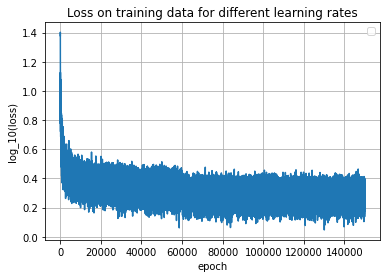

In [222]:
plt.plot(losses)
plt.xlabel("epoch")
plt.ylabel("log_10(loss)")
plt.title("Loss on training data for different learning rates")
plt.legend()
plt.grid() 
plt.plot()

In [223]:
emb = c[x]
h = torch.tanh(emb.view(-1, w1.shape[0]) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, y)
print(f"loss (whole dataset): {loss}")

loss (whole dataset): 2.034259557723999


In [224]:
emb = c[x_val]
h = torch.tanh(emb.view(-1, w1.shape[0]) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, y_val)
print(f"loss (validation set): {loss}")

loss (validation set): 2.415937900543213


**Commet**: We definetely managed to overfit the network :().

## Sampling from the model

In [226]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = c[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ w1 + b1)
      logits = h @ w2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmahzabelle.
khi.
mili.
tatya.
kanson.
jazhnee.
den.
art.
kaeli.
nez.
kea.
chaiir.
kaleigh.
ham.
pock.
quinn.
shline.
lianni.
want.
paitarusitt.
